# Поиска изображений по запросу


Требуется разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

<font color='green'>Цель</font>

Найти изображение по запросу

<font color='green'>Задачи</font>

- исследовать данные;
- добавить аугментации при необходимости;
- достигнуть показателя метрики 'mae' < 8.


<font color='green'>Файлы</font>

- `train_dataset.csv` - информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.
- `train_images` - папка с фотографиями.
- `CrowdAnnotations.tsv` - данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

- `ExpertAnnotations.tsv` - данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

- `test_queries.csv` - информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.
- `test_images` - изображения для тестирования модели.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Векторизация-текста-и-проверка-данных" data-toc-modified-id="Векторизация-текста-и-проверка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Векторизация текста и проверка данных</a></span></li><li><span><a href="#Векторизация-изображений" data-toc-modified-id="Векторизация-изображений-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Векторизация изображений</a></span></li><li><span><a href="#Объединение-векторов" data-toc-modified-id="Объединение-векторов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Объединение векторов</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Выбор модели</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, GroupShuffleSplit
from sklearn.metrics import  mean_squared_error, make_scorer
from sklearn.dummy import  DummyRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import torch
from torch import cuda
import torch.nn as nn

import skorch
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor

from tqdm import notebook
from tqdm import tqdm, tqdm_notebook 

from img2vec_pytorch import Img2Vec
import re
import spacy
import PIL
import transformers 
import pickle
import json
import random
import time

Посмотрим на табличные данные.

In [2]:
data_1 = pd.read_csv('/ML/datasets/to_upload/train_dataset.csv')
data_1

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [3]:
data_2 = pd.read_csv('/ML/datasets/to_upload/CrowdAnnotations.tsv', sep='\t', header=None)
data_2.columns = ['image', 'query_id', 'user_rating', '3', '4']
data_2

,image,query_id,user_rating,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


In [4]:
data_3 = pd.read_csv('/ML/datasets/to_upload/ExpertAnnotations.tsv', sep='\t',  header=None)
data_3.columns = ['image', 'query_id', '2', '3', '4']
data_3

,image,query_id,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


Подготовим целевой признак - `rating`.

In [5]:
# оценка экспертов берется как среднее с округлением до целого
data_3['expert_rating'] = ((data_3['2'] + data_3['3'] + data_3['4'])/3).astype(int)

data = data_1.merge(data_2, on=['image', 'query_id'], how='left').merge(data_3, on=['image', 'query_id'], how='left')  
data = data[['image', 'query_id', 'query_text', 'user_rating', 'expert_rating']]
# нормализация оценки экспертов
data['expert_rating'] = (data['expert_rating'] - data['expert_rating'].min()) / (data['expert_rating'].max() \
                                        - data['expert_rating'].min())

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          5822 non-null   object 
 1   query_id       5822 non-null   object 
 2   query_text     5822 non-null   object 
 3   user_rating    2329 non-null   float64
 4   expert_rating  5822 non-null   float64
dtypes: float64(2), object(3)
memory usage: 272.9+ KB


Больше чем в половине данных отсутствует `user_rating`.
Учитывая это, договоримся о следующем:

`rating` (итоговая оценка) = `expert_rating`

In [7]:
data['rating'] = data['expert_rating']

In [8]:
data['rating'].value_counts().head(10)

0.000000    4004
0.333333    1195
0.666667     376
1.000000     247
Name: rating, dtype: int64

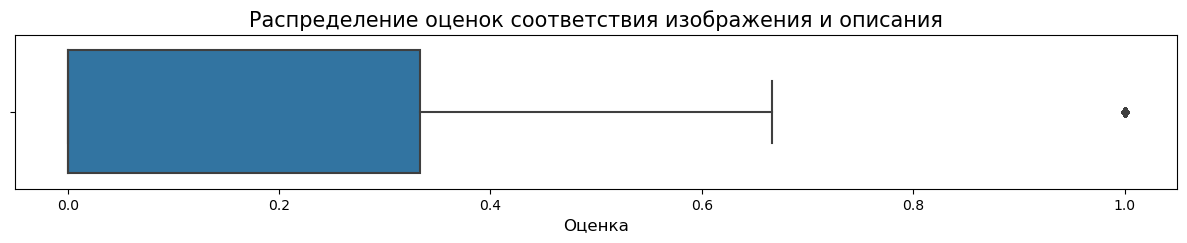

In [9]:
plt.figure(figsize=(15, 2))
ax = sns.boxplot(x=data['rating']);
ax.set_title('Распределение оценок соответствия изображения и описания', fontsize=15)
ax.set_xlabel('Оценка', fontsize=12);

Имеющиеся оценки сильно смещены к нулю.

Посмотрим на изображения.

In [10]:
images = list(pd.unique(data['image']))
all_images =[]

for each in images:
    image = PIL.Image.open('/ML/datasets/to_upload/train_images/' + each)
    all_images.append(image)

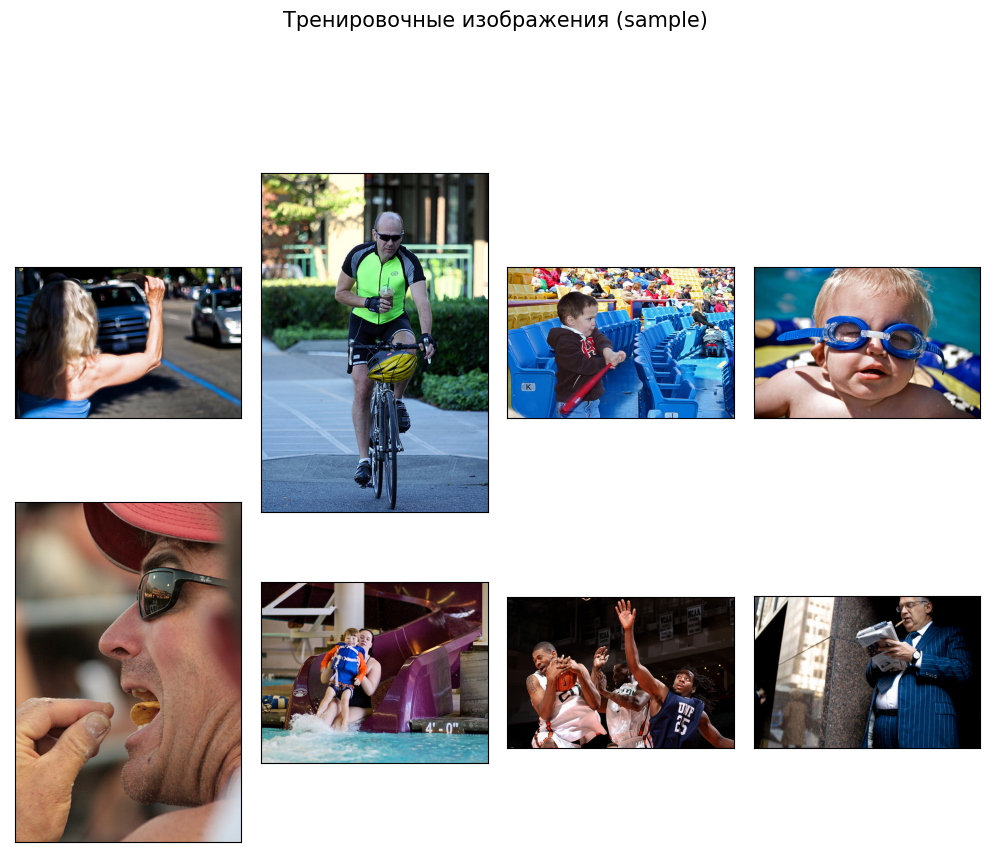

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.suptitle('Тренировочные изображения (sample)', fontsize=15)
    fig.add_subplot(2, 4, i+1)    
    plt.imshow(all_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() 

**Вывод**

Данные загружены. Из-за значительных пропусков в `user_rating` за целевую переменную решено взять `expert_rating`. 

Имеющиеся оценки сильно смещены к нулю.

## Векторизация текста и проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Векторизируем текст и удалим описания + соответствующие им изображения, которые нарушают данный закон.

In [12]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [13]:
def lemma(doc):
    text = ' '.join([i for i in doc.lower().split()]) # строчные буквы + без стоп-слов
    text = re.sub(r'[^a-z\'\-]', ' ', text) 
    text = re.sub(r'\s+', ' ', text) # только одинарные пробелы
    text = text.strip() # без пробел в начале/конце
    text = nlp(doc)
    text = ' '.join([token.lemma_ for token in text])
    return text

def preprocess_text_bert(doc):
    text = re.sub(r'[^a-zA-Z\'\-]', ' ', doc) 
    text = re.sub(r'\s+', ' ', text) # только одинарные пробелы
    text = text.strip() # без пробел в начале/конце
    return text

def finde_to_delete(text):
    words = ['child', 'baby', 'boy', 'girl', 'kid']
    for word in words:
        if word in text.lower(): 
            return 1
    return 0 

def tokenize_bert(doc): 
    text = tokenizer.encode(doc, add_special_tokens=True, truncation=True, max_length=512) 
    return text

In [14]:
data['lemma'] = [lemma(t) for t in data['query_text']]
data['lemma_BERT'] = [preprocess_text_bert(t) for t in data['query_text']]

data['to_delete'] = [finde_to_delete(t) for t in data['query_text']]
data['to_delete'].value_counts()

0    4275
1    1547
Name: to_delete, dtype: int64

In [15]:
data = data.loc[data['to_delete'] != 1].reset_index()

In [16]:
features_text = [tokenize_bert(t) for t in data['lemma_BERT']]

In [17]:
model_text = model_class.from_pretrained(pretrained_weights)

max_len = 0
for i in features_text:
    if len(i) > max_len:
        max_len = len(i)  
        
def bert_transform(df):
    padded = np.array([i + [0]*(max_len - len(i)) for i in df])
    attention_mask = np.where(padded != 0, 1, 0)

    batch_size = 100
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size +1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_text(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        
    features = np.concatenate(embeddings)        
    return features

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
features_text = bert_transform(features_text)

  0%|          | 0/43 [00:00<?, ?it/s]

In [19]:
features_text.shape

(4275, 768)

**Вывод**

Текст векторизирован с помощью BERT. Исключены описания, содержащие ключевые слова из списка: ['child', 'baby', 'boy', 'girl', 'kid'].
Удалено 1547 значений из 5822. Размер полученного вектора: (4275, 768)

## Векторизация изображений

In [20]:
def vector(images, img_path):
    
    img2vec = Img2Vec(cuda=(torch.cuda.is_available()))
    
    fe_img = []
    for image in images:
        img = PIL.Image.open(img_path + image)
        vec = img2vec.get_vec(img)
        fe_img.append(vec)
        
    fe_img = pd.DataFrame(fe_img)
    fe_img.columns = ['img_vec_' + str(i) for i in range(fe_img.shape[1])]
    return fe_img
    

In [21]:
%%time

images_train = list(data['image'])    
path_1 = '/ML/datasets/to_upload/train_images/'

features_train_images = vector(images_train, path_1)
features_train_images.shape

C:\Users\white\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\white\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: total: 20min 22s
Wall time: 3min 24s


(4275, 512)

In [22]:
%%time

df = pd.read_csv('/ML/datasets/to_upload/test_images.csv')
images_test = list(pd.unique(df['image']))
path_2 = '/ML/datasets/to_upload/test_images/'

features_test_images = vector(images_test, path_2)
features_test_images.shape

C:\Users\white\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\white\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: total: 30.4 s
Wall time: 5.22 s


(100, 512)

**Вывод**

Изображения векторизированы c помощью `Img2Vec`. Размеры полученных векторов: 

- train: (4275, 512)
- test: (100, 512)

## Объединение векторов

In [23]:
print(features_text.shape)
print(features_train_images.shape)

(4275, 768)
(4275, 512)


In [24]:
features = np.concatenate((features_text, features_train_images), axis=1)
target = data['rating']
print(features.shape)

(4275, 1280)


**Вывод**

Вектор изображений объединен с вектором описания. Размер полученного вектора: (4275, 1280).

## Обучение модели 

Разделим данные на train и test.

In [25]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=1234)
train_indices, test_indices = next(gss.split(X=features, y=target, groups=data['image']))

features_train, features_test = features[train_indices], features[test_indices]
target_train, target_test = target[train_indices], target[test_indices]

In [26]:
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(3011, 1280) (3011,) (1264, 1280) (1264,)


Создадим класс для нейронки.

In [27]:
class Model_improve(nn.Module):
    def __init__(self, n_hidden_neurons_1=10, n_hidden_neurons_2=10, activation_1=nn.ELU(), activation_2=nn.ELU(), 
                 activation_3=nn.ReLU(), dropout_1=0, dropout_2=0, optimizer=torch.optim.Adam):
        super(Model_improve, self).__init__()
        
        
        self.layer1 = nn.Linear(X_train_tensor.shape[1], n_hidden_neurons_1)
        self.act1 = activation_1 
        self.dp1 = nn.Dropout(dropout_1)
        
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation_2    
        self.dp2 = nn.Dropout(dropout_2)
        
        self.layer3 = nn.Linear(n_hidden_neurons_2, 1)
        self.act3 = activation_3    
        
        self.layer_names = ['layer1', 'layer2', 'layer3']
        self.optimizer = optimizer
        
    def init_weights(self):
        for layer in self.layer_names:
            if type(layer) == nn.Linear: 
                nn.init.normal_(layer.weight, mean= 0.0, std=1.14)
                nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 
    
           
    def forward(self, x):
        
        self.init_weights()
        
        
        x = self.layer1(x)
        x = self.act1(x)
        x = self.dp1(x)
        
        x = self.layer2(x)
        x = self.act2(x)
        x = self.dp2(x)
        
        x = self.layer3(x)
        x = self.act3(x)
        return x    

### Выбор модели

In [28]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)    
    random.Random(seed) # для dropout

set_random_seed(12345)

def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)


scorers = make_scorer(mean_squared_error, squared=False) 

regressions = [
                LinearRegression(),
                LGBMRegressor(random_state=12345),
                NeuralNetRegressor(module=Model_improve, 
                                      verbose=0,
                                      batch_size=8,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=500, 
                                      lr=0.001,
                                      train_split=skorch.dataset.ValidSplit(10), 
                                      criterion=torch.nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=scorers, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=5))
                                                ]
                                   ) 
              ]

regressions_dict = {0: 'LinearRegression',
                    1: 'LGBM',
                    2: 'SkorchRegressor'
                    }

param = {
             0:{},
             1:{'learning_rate': [0.001, 0.01, 0.1]},
             2:{'module__n_hidden_neurons_1': [100, 1000],
                'module__n_hidden_neurons_2': [100, 1000],                
        
                'module__dropout_1': [0, 0.1],
                'module__dropout_2': [0, 0.1],
    
                'module__activation_1': [nn.ELU()],
                'module__activation_2': [nn.ReLU()],
                'module__activation_3': [nn.ELU()],
        
                'optimizer__lr': [0.001],
                'lr': [0.001],
                'batch_size': [100]
              }
        }


best_rmse = 1
best_param = 0
best_model = ''
best_model_index = ''
index = 0
test = 0

for reg in regressions:

    start = time.time()
    
    model = GridSearchCV(estimator=reg, param_grid=param[index], scoring='neg_mean_squared_error', cv=3) 

    if index != 2:     
        model.fit(features_train, target_train)
        predicted_train = model.best_estimator_.predict(features_train)
        predicted_test = model.best_estimator_.predict(features_test)

    else:  
        X_train_tensor = torch.FloatTensor(features_train) 
        X_test_tensor = torch.FloatTensor(features_test)
        y_train_tensor = torch.FloatTensor(target_train.values)
        y_test_tensor = torch.FloatTensor(target_test.values)

        model.fit(X_train_tensor, y_train_tensor.reshape(-1,1)) 
        predicted_train = model.best_estimator_.predict(X_train_tensor)
        predicted_test = model.best_estimator_.predict(X_test_tensor)

    predicted_train = np.clip(predicted_train, 0., 1.)
    rmse_train = mean_squared_error(target_train, predicted_train, squared=False)
    predicted_test = np.clip(predicted_test, 0., 1.)
    rmse_test = mean_squared_error(target_test, predicted_test, squared=False) 

    if rmse_train < best_rmse:
        best_rmse = rmse_train
        best_model_index = regressions_dict[index]
        best_model = reg
        best_param = model.best_params_
        test = rmse_test

        # сохранение модели
        final_model = 'finalized_model.sav'
        pickle.dump(model, open(final_model, 'wb'))
            
        with open('config.json', 'w') as f:
            json.dump(best_param, f)

    end = time.time()       
    print('\nМодель: {}'.format(regressions_dict[index]))
    print('Лучшие параметры : {}'.format(model.best_params_))
    print('Лучшее значение RMSE на train: {:.4f}'.format(rmse_train))
    print("Общее время:", exec_time(start,end))
    index += 1


Модель: LinearRegression
Лучшие параметры : {}
Лучшее значение RMSE на train: 0.1794
Общее время: 00:00:01

Модель: LGBM
Лучшие параметры : {'learning_rate': 0.1}
Лучшее значение RMSE на train: 0.0623
Общее время: 00:00:28

Модель: SkorchRegressor
Лучшие параметры : {'batch_size': 100, 'lr': 0.001, 'module__activation_1': ELU(alpha=1.0), 'module__activation_2': ReLU(), 'module__activation_3': ELU(alpha=1.0), 'module__dropout_1': 0, 'module__dropout_2': 0.1, 'module__n_hidden_neurons_1': 1000, 'module__n_hidden_neurons_2': 1000, 'optimizer__lr': 0.001}
Лучшее значение RMSE на train: 0.2367
Общее время: 00:03:18


**Вывод**

In [29]:
print('\nМодель с лучшим значением RMSE на train: {}'.format(best_model_index))
print('Значение RMSE на test: {:.4f}'.format(test))
print('Параметры лучшей модели:', best_param)


Модель с лучшим значением RMSE на train: LGBM
Значение RMSE на test: 0.2461
Параметры лучшей модели: {'learning_rate': 0.1}


## Тестирование модели

In [30]:
def predict_image(features_test_images, index, n_sample):
    
      
        def predict_index(features_test_images, j=index, n=n_sample):
    
            df = pd.read_csv('/ML/datasets/to_upload/test_queries.csv', sep= '|')
            df = df.sample(n=n, random_state=12345).reset_index(drop=True)
            
            df['lemma'] = [lemma(t) for t in df['query_text']]
            df['to_delete'] = [finde_to_delete(t) for t in df['query_text']]
            df['lemma_BERT'] = [preprocess_text_bert(t) for t in df['query_text']]
            features_text = [tokenize_bert(t) for t in df['lemma_BERT']]

            model_text = model_class.from_pretrained(pretrained_weights)

            max_len = 0
            for i in features_text:
                if len(i) > max_len:
                    max_len = len(i)   
        
            features_test_text = bert_transform(features_text)
    
            features = pd.DataFrame()
            for i in range(len(features_test_images)):
                features[i] = np.concatenate((features_test_images.iloc[i], features_test_text[j]), axis=0)
            features = features.T
    
            
            with open('config.json', 'r') as f:
                config = json.load(f)
            f_model = pickle.load(open(final_model, 'rb'))
            f_model.set_params(param_grid=config)
    
            predicted_train = f_model.predict(features)
            predicted_train = np.clip(predicted_train, 0., 1.)
     
            return np.argmax(predicted_train), df.iloc[j]['query_text'], predicted_train[np.argmax(predicted_train)], df.iloc[j]['to_delete']
         
        index, text, rating, flag = predict_index(features_test_images)
        image = PIL.Image.open('/ML/datasets/to_upload/test_images/' + images_test[index])
        
        if flag != 1:
            print(f'text: {text}')
            print(f'rating: {rating}')             
           
            plt.figure()
            plt.imshow(image) 
            plt.show()  
            
        else:
            print(f'text: {text}')
            print('This image is unavailable in your country in compliance with local laws')            

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: A dog is wearing jeans and a blue and yellow shirt with a black vehicle in the background .
rating: 0.48648949563535604


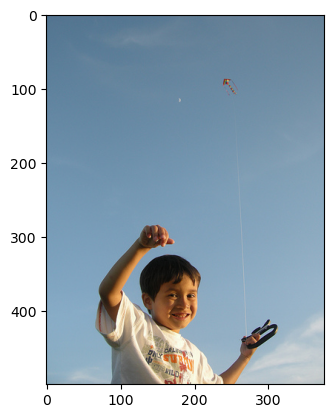

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: While holding tight to the ball , the man in red socks is getting tackled .
rating: 0.3535312990803499


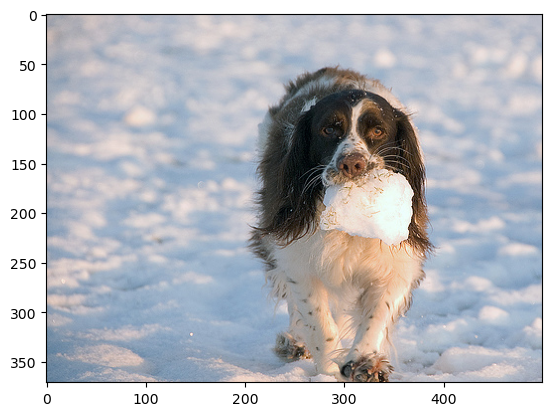

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: A dog is dressed in a shirt and pants on the side of the road .
rating: 0.4390065850412343


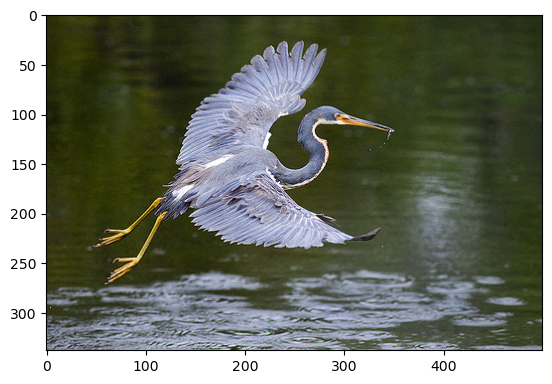

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: a biker rides down the street .
rating: 0.47943922489228435


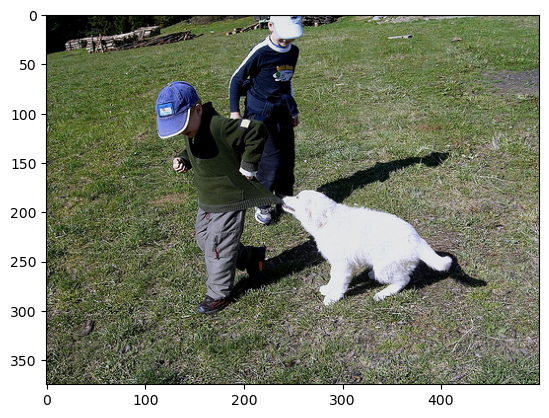

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: a kickboxer jumping for a kick
rating: 0.42791290564057943


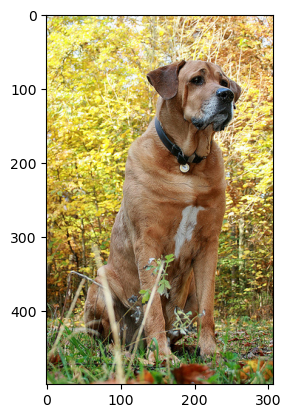

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: A young boy wearing a red shirt stands in the street with his arms open wide .
This image is unavailable in your country in compliance with local laws


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: A woman in purple with two children in the mouth of a cave .
This image is unavailable in your country in compliance with local laws


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: A little girl dressed in a pink shirt , blue shorts and a pink hair ribbon feeding ducks that are swimming in water .
This image is unavailable in your country in compliance with local laws


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: a family standing in a rock cave with some of their belongings in the background
rating: 0.4348066687408088


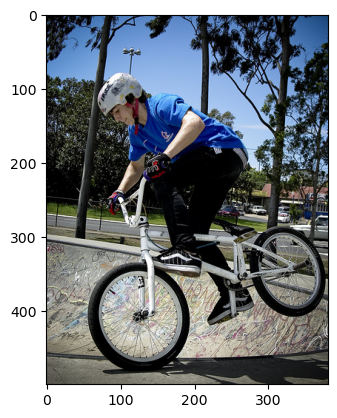

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1 [00:00<?, ?it/s]

text: Three people are looking into photographic equipment .
rating: 0.3976510121927344


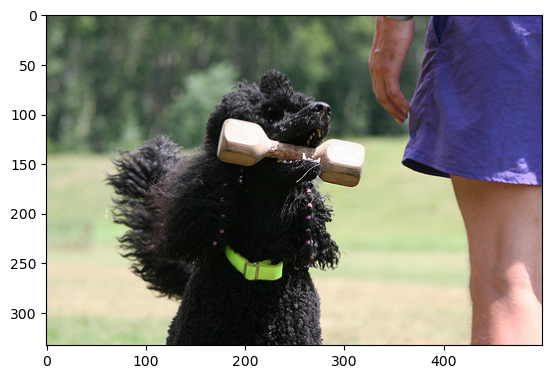

In [31]:
for k in range(10): 
    predict_image(features_test_images, k, 10)

**Вывод**

In [32]:
print('\nМодель с лучшим значением RMSE на train: {}'.format(best_model_index))
print('Значение RMSE на test: {:.4f}'.format(test))
print('Параметры лучшей модели:', best_param)


Модель с лучшим значением RMSE на train: LGBM
Значение RMSE на test: 0.2461
Параметры лучшей модели: {'learning_rate': 0.1}


Модель не нашла подходящие изображения ни для одного из 10 запросов (rating < 0.5). Требуется больше данных для обучения.